In [ ]:
# DO NOT REMOVE

# Building the distributed seismicity model

In [1]:
%matplotlib inline
import os
import re
import h5py
import numpy
import scipy
import pickle
import matplotlib.pylab as plt
from decimal import *
getcontext().prec = 4

from copy import deepcopy

from openquake.mbt.oqt_project import OQtProject, OQtSource
from openquake.mbt.tools.area import create_catalogue
from openquake.mbt.tools.smooth import Smoothing
from openquake.mbt.tools.geo import get_idx_points_inside_polygon

from openquake.hazardlib.sourcewriter import write_source_model
from openquake.hazardlib.source import PointSource, SimpleFaultSource
from openquake.hazardlib.mfd.evenly_discretized import EvenlyDiscretizedMFD
from openquake.hazardlib.geo.point import Point
from openquake.hazardlib.geo.geodetic import azimuth, point_at

from openquake.hmtk.seismicity.selector import CatalogueSelector

from openquake.hazardlib.scalerel.wc1994 import WC1994
from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.pmf import PMF
from openquake.hazardlib.geo.nodalplane import NodalPlane 
from openquake.hazardlib.mfd import TruncatedGRMFD

## Loading the model and area source

In [2]:
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
prj_dir = os.path.dirname(project_pickle_filename)
print ('Active model ID is:', model_id)
area_discretization = model.area_discretization

Active model ID is: model01


In [3]:
src_id = getattr(oqtkp,'active_source_id')[0]
print ('Area source ID:', src_id)
src = model.sources[src_id]

Area source ID: S


## Set the nodal plane distribution 

In [4]:
# 
# set the nodal plane distribution
nodal_plane_dist_filename = os.path.join(prj_dir, model.nodal_plane_dist_filename)
fhdf5 = h5py.File(nodal_plane_dist_filename,'r')
#
# add the dataset for the current area source, if missing
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['strike'][0] == 0) and 
                                    (fhdf5[src_id]['dip'][0] == 0) and
                                    (fhdf5[src_id]['rake'][0] == 0))):
    print ('Using source-specific nodal plane distribution')
    data = fhdf5[src_id][:]
    tpll = []
    for idx in range(0, len(data)):
        nplane = NodalPlane(data['strike'][idx],
                            data['dip'][idx],
                            data['rake'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
else:
    print ('Using default nodal plane distribution')
    tpll = []
    npd = model.default_nodal_plane_dist
    for idx in range(0, len(npd['strike'])):
        nplane = NodalPlane(npd['strike'][idx],
                            npd['dip'][idx],
                            npd['rake'][idx])
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), nplane))
nodal_plane_distribution = PMF(tpll)    
fhdf5.close()

Using source-specific nodal plane distribution


## Set the hypocentral depth distribution

In [5]:
# 
# read hypocentral depth file
hypo_dist_filename = os.path.join(prj_dir, model.hypo_dist_filename)
fhdf5 = h5py.File(hypo_dist_filename,'r')
#
# check if the file contains information relative this source
if (src_id in fhdf5.keys() and not ((fhdf5[src_id]['depth'][0] == 0) and 
                                    (fhdf5[src_id]['wei'][0] == 0))):
    print('Using source-specific hypocentral depth distribution')
    data = fhdf5[src_id][:]
    tpll = []
    for idx in range(0, len(data)):
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), data['depth'][idx]))
else:
    print('Using default hypocentral depth distribution')
    tpll = []
    hdd = model.default_hypo_dist
    for idx in range(0, len(hdd['dep'])):
        tmp = Decimal('{:.2f}'.format(data['wei'][idx]))
        tpll.append((Decimal(tmp), data['depth'][idx]))
hypocenter_distribution = PMF(tpll)    

Using source-specific hypocentral depth distribution


## Create the dilated polygon around the area source

In [6]:
new_polygon = src.polygon.dilate(100)
polygon_mesh = new_polygon.discretize(area_discretization)
print ('Number of points: %d' % (len(polygon_mesh)))

Number of points: 25228


In [7]:
#
# get the earthquakes of the catalogue within the dilated polygon 
pickle_filename = os.path.join(prj_dir, oqtkp.models[model_id].declustered_catalogue_pickle_filename)
fin = open(pickle_filename, 'rb') 
catalogue = pickle.load(fin)
fin.close()
print ('The calogue contains %d earthquakes' % (len(catalogue.data['magnitude'])))

The calogue contains 637 earthquakes


In [8]:
#
# create the subcatalogue for the dilated polygon
cutoff_magnitude = float(model.catalogue_cutoff_magnitude)
fcatal = create_catalogue(model, catalogue, polygon=new_polygon)
selector = CatalogueSelector(catalogue, create_copy=False)
tmp = selector.within_magnitude_range(cutoff_magnitude, 10.)

## Smoothing 

In [9]:
smooth_param = model.smoothing_param
smooth = Smoothing(fcatal, polygon_mesh, 10)

In [10]:
values = smooth.multiple_smoothing(smooth_param)
print ('Max smoothing value:', max(values))

Max smoothing value: 0.8234589854271486


## Map with the smoothed grid

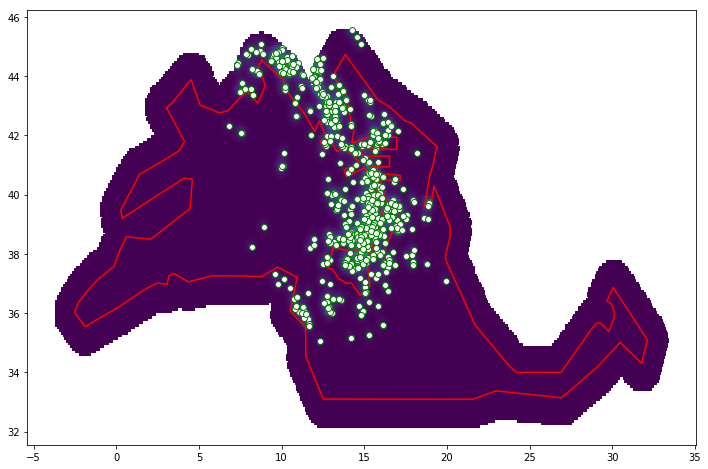

In [11]:
fig = plt.figure(figsize=(12,8))
tmp = plt.scatter(smooth.mesh.lons, smooth.mesh.lats, c=values, vmin=0, vmax=max(values), marker='s', s=15)
tmp = plt.plot(src.polygon.lons, src.polygon.lats, 'r')
tmp = plt.plot(fcatal.data['longitude'], fcatal.data['latitude'], 'og', mfc='white')

In [12]:
%%bash
rm tmp*

## Select the nodes of the grid within the area source

In [13]:
idxp = smooth.get_points_in_polygon(src.polygon)

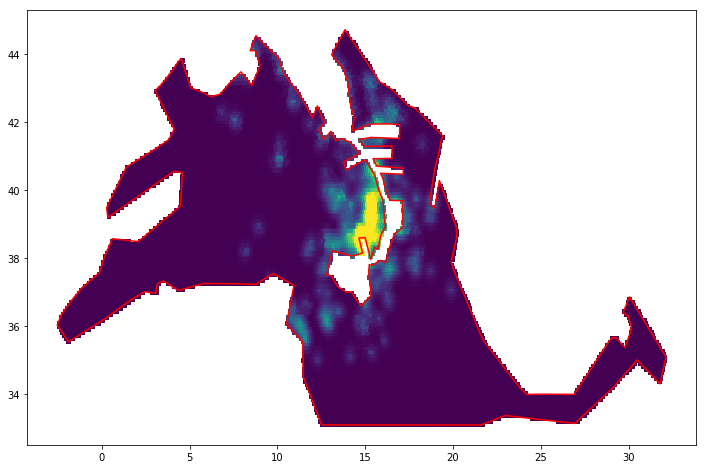

In [14]:
fig = plt.figure(figsize=(12,8))
plt.scatter(smooth.mesh.lons[idxp], smooth.mesh.lats[idxp], vmin=0, vmax=0.4, c=values[idxp], marker='s', s=15)
plt.plot(src.polygon.lons, src.polygon.lats, 'r')
if 'ids_faults_inside' in src.__dict__:
    for iii, key in enumerate(sorted(src.ids_faults_inside.keys())): 
        tsrc = model.sources[key] 
        coord = numpy.array(get_polygon_from_simple_fault(tsrc))
        plt.plot(coord[:,0], coord[:,1], 'r')

## Assign seismicity to the source
The redistribution of seismicity to the source is done for each cell using as a scaling factor the ratio of the value assigned to the node and the sum of the values of all the nodes within the area source. Note that the mfd assigned to the area source must be an EvenlyDiscretisedMFD instance.

In [15]:
scaling_factor = 1. /sum(values[idxp])
#
# if necessary convert a TruncatedGR into a EvenlyDiscretizedMFD 
if isinstance(src.mfd, TruncatedGRMFD):
    src.mfd.get_annual_occurrence_rates
    tmp = src.mfd.get_annual_occurrence_rates()
    mfd = EvenlyDiscretizedMFD(tmp[0][0], tmp[1][0] - tmp[0][0], tmp[:][1]) 
else:
    mfd = source.mfd
#
# compute scaled rates
mfdpnts = numpy.array([mfd.occurrence_rates,]*len(values))*scaling_factor
#
#
xxx = numpy.tile(values, (mfdpnts.shape[1], 1)).T
mfdpnts = mfdpnts * numpy.tile(values, (mfdpnts.shape[1], 1)).T
#
# create a vector of magnitude values
mags = []
for mag, _ in mfd.get_annual_occurrence_rates():
    mags.append(mag)

# Create the nrml 

In [16]:
model.upper_seismogenic_depth = float(model.upper_seismogenic_depth)
model.lower_seismogenic_depth = float(model.lower_seismogenic_depth)

print ("model upper seismogenic depth: {:.2f}".format(model.upper_seismogenic_depth))
print ("model lower seismogenic depth: {:.2f}".format(model.lower_seismogenic_depth))

for tple in hypocenter_distribution.data:
    print (tple)

nrmls = [] 
#
# settings
rupture_mesh_spacing = 2.5
magnitude_scaling_relationship = WC1994()
rupture_aspect_ratio = 2.0
temporal_occurrence_model = PoissonTOM(1.)
#
# loop on the points inside the polygon
for eee, iii in enumerate(idxp):
    #
    # check if the discrete MFD for this point has values larger than 0
    jjj = numpy.nonzero(mfdpnts[iii, :] > 0)
    if len(list(mfdpnts[iii, jjj][0])) > 0:
        #
        # create the MFD
        tmfd = EvenlyDiscretizedMFD(src.mfd.min_mag, src.mfd.bin_width, list(mfdpnts[iii, jjj][0]))
        #
        # create the point source
        points = PointSource(
            source_id='{:s}_{:d}'.format(src.source_id, eee), 
            name='', 
            tectonic_region_type=src.tectonic_region_type,
            mfd=tmfd, 
            rupture_mesh_spacing=rupture_mesh_spacing,
            magnitude_scaling_relationship=magnitude_scaling_relationship, 
            rupture_aspect_ratio=rupture_aspect_ratio,
            temporal_occurrence_model=temporal_occurrence_model,
            upper_seismogenic_depth=model.upper_seismogenic_depth, 
            lower_seismogenic_depth=model.lower_seismogenic_depth,
            location=Point(smooth.mesh.lons[iii], smooth.mesh.lats[iii]), 
            nodal_plane_distribution=nodal_plane_distribution, 
            hypocenter_distribution=hypocenter_distribution
            )
        nrmls.append(points)

model upper seismogenic depth: 0.00
model lower seismogenic depth: 25.00
(1.0, 11.0)


In [17]:
#
# write the nrml file
model_dir = os.path.join(prj_dir, 'nrml/%s' % (re.sub('\s','_',model_id)))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_name = '%s_gridded_seismicity_source_%s.xml' % (model_id, src_id)
out_model_name = os.path.join(model_dir, model_name)
_ = write_source_model(out_model_name, nrmls, 'Model {:s}'.format(model.name))
print('Created %s ' % (out_model_name))

Created /Users/mpagani/Repos/models/phase3/ita19/model/crustal/model01/nrml/model01/model01_gridded_seismicity_source_S.xml 
